In [12]:
!pip3 install -q tfds-nightly matplotlib
!pip3 install tensorflow_addons

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import matplotlib.pyplot as plt 

print(tf.__version__)

2.4.0


In [15]:
# all dataset is in one split called train with 17509 images.
# we split as in the paper 60% - 20% - 20% , Training - Validation - Test.
# the following lignes of code do exactly that.

data_train, train_info = tfds.load("deep_weeds", with_info=True, split='train[:60%]')
data_valid, val_info  = tfds.load("deep_weeds",with_info=True,split='train[60%:80%]')
data_test,test_info = tfds.load("deep_weeds",with_info=True, split='train[80%:]')

 completed...: 0 file [04:55, ? file/s]
Dl Completed...:  50%|█████     | 1/2 [04:56<00:01,  1.32s/ url]
Dl Size...: 380 MiB [04:56,  1.46 MiB/s]

Extraction completed...: 0 file [04:56, ? file/s]
Dl Completed...:  50%|█████     | 1/2 [04:57<00:01,  1.32s/ url]
Dl Size...: 381 MiB [04:57,  1.46 MiB/s]

Extraction completed...: 0 file [04:57, ? file/s]
Dl Completed...:  50%|█████     | 1/2 [04:57<00:01,  1.32s/ url]
Dl Size...: 382 MiB [04:57,  1.56 MiB/s]

Extraction completed...: 0 file [04:57, ? file/s]
Dl Completed...:  50%|█████     | 1/2 [04:58<00:01,  1.32s/ url]
Dl Size...: 383 MiB [04:58,  1.58 MiB/s]

Extraction completed...: 0 file [04:58, ? file/s]
Dl Completed...:  50%|█████     | 1/2 [04:58<00:01,  1.32s/ url]
Dl Size...: 384 MiB [04:58,  1.66 MiB/s]

Extraction completed...: 0 file [04:58, ? file/s]
Dl Completed...:  50%|█████     | 1/2 [04:59<00:01,  1.32s/ url]
Dl Size...: 385 MiB [04:59,  1.67 MiB/s]

Extraction completed...: 0 file [04:59, ? file/s]
Dl Completed...:  

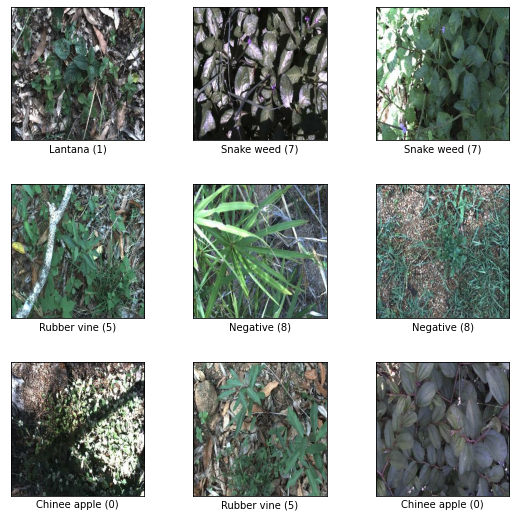

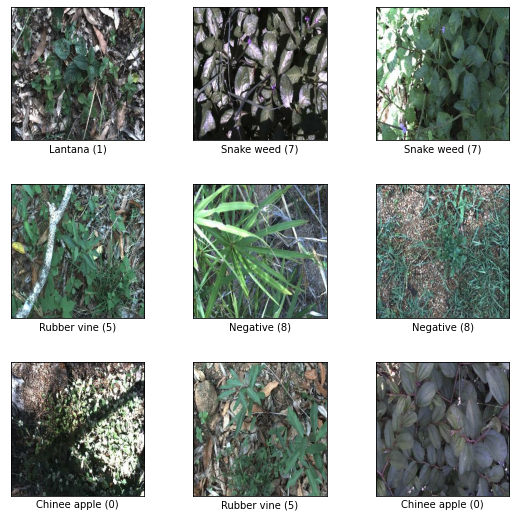

In [16]:
# A preview of the images in the dataset
tfds.show_examples(data_train,train_info)

In [17]:
data = list(data_train.take(1)) #taking one example from the training dataset!
data[0]['image'].shape #we print the shape of the image

TensorShape([256, 256, 3])

In [22]:
import numpy as np
def preprocess_weeds(dic):
  '''preprocessing of images

  Args:
    Dict: image,label

  Returns:
    resized image and scaled
  '''
  image = dic['image']
  preprocessed_image = tf.image.resize(image,[224,224])/255 # Scale to between 0 and 1 & resize to 224 for resnet-50 input
  label = dic['label']
  return preprocessed_image, label

def zoom(x: tf.Tensor) -> tf.Tensor:
    '''Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    '''

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(img, boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

def augment(image,label):
  '''
    this augmentor simulates the series of augmentation made in the paper!
    + random rotation
    +

  '''
 
  #image = zoom([image])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.random_flip_left_right(image) # random hoeizontal flip
  image = tf.image.random_flip_up_down(image) # random vertical flip
  image = tf.image.random_hue(image, max_delta=0.1) #random shiffting of the channels
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3) # Adjust contrast
  delta = tf.random.uniform([], minval = math.radians(-360),maxval = math.radians(360), dtype=tf.float32)
  image = tf.image.rot90(image, tf.dtypes.cast(delta,tf.int32)) #random rotation
  return image, label

# Use the batch method to prepare batches.
data_train_gen = (data_train
                  .map(preprocess_weeds)
                  .cache()
                  .map(augment,num_parallel_calls = tf.data.experimental.AUTOTUNE)
                  .batch(32)
                  .prefetch(tf.data.experimental.AUTOTUNE))
data_valid_gen = data_valid.map(preprocess_weeds).cache().batch(32)
data_test_gen = data_test.map(preprocess_weeds).batch(32)

In [23]:
from tensorflow.keras.layers import Input, Dense, Flatten

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

image_input = Input((224,224,3))
resnet = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet")
NUM_CLASSES=9
model = tf.keras.Sequential(
    [image_input,
     resnet,
     tf.keras.layers.AveragePooling2D(),
     tf.keras.layers.Flatten(),
     Dense(NUM_CLASSES, activation = "softmax")])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss = "sparse_categorical_crossentropy",metrics = "accuracy")
history = model.fit(data_train_gen,epochs = 200, batch_size=32, validation_data = data_valid_gen)

ModuleNotFoundError: No module named 'tensorflow.python.keras.engine.base_layer_v1'

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9524326706979857723
]


In [19]:
tf.config.list_physical_devices("GPU")

[]

SyntaxError: invalid syntax (<ipython-input-8-0b23733f3e06>, line 1)

In [20]:
tf.test.gpu_device_name()


''